# Conditional edges in graph

https://langchain-ai.github.io/langgraph/concepts/why-langgraph/

https://langchain-ai.github.io/langgraph/reference/

https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph.add_conditional_edges

* A decision function (a.k.a. router logic function) is a needed for deciding the next node
* A decision function note is NOT added via the add_node function
* The decision function node gets added to the graph via **add_condition_edges(..)** function



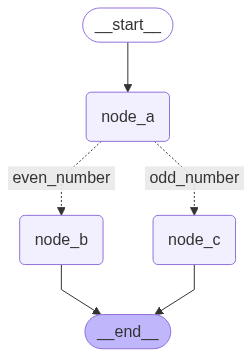

Random generated : 1
node_c received odd number : 1
{'rint': 1}


In [21]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
import random


class StateBasic(TypedDict):
    rint: int  # Holds a random integer

# This is a decision node 
# The conditional edge logic will be injected at this node
def node_a(state: StateBasic)->dict:
    rint = random.randint(1, 100)
    print(f"Random generated : {rint}")
    return {"rint": rint}

# Called when the random number is even
def node_b(state: StateBasic):
    print(f"node_b received even number : {state["rint"]}")
    return {}

# Called when the random number is odd
def node_c(state: StateBasic):
    print(f"node_c received odd number : {state["rint"]}")
    return {}

# Router logic
def router_logic(state: StateBasic)->str:
    if (state["rint"] % 2) == 0:
        return "even_number"
    else:
        return "odd_number"
        
# Create a graph builder object
workflow = StateGraph(StateBasic)

# Add the nodes
workflow.add_node("node_a", node_a)
workflow.add_node("node_b", node_b)
workflow.add_node("node_c", node_c)


# Add the edges
workflow.add_edge(START, "node_a")

workflow.add_conditional_edges( "node_a", 
                                
                                router_logic,
                                
                                 {
                                     "even_number": "node_b",
                                     "odd_number" : "node_c"
                                 })
workflow.add_edge("node_b",END)
workflow.add_edge("node_c",END)

# Compile to an executable graph
workflow_compiled = workflow.compile()

# visulaize the graph
from IPython.display import Image, display
display(Image(workflow_compiled.get_graph().draw_mermaid_png()))

# Invoke the graph
# First node takes an int so pass an int as input
response = workflow_compiled.invoke({})

# Print
print(response)

# Looping behavior

* The router logic decides whether the loop continues or exit
* In  this example the state maintains variables for number-of-iterations and current-iterations-completed

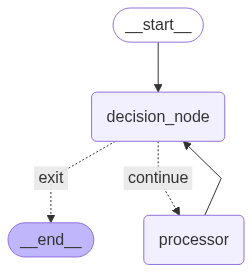

Processing iteration # 1
Processing iteration # 2
Processing iteration # 3
Processing iteration # 4
Processing iteration # 5
Processing iteration # 6


In [24]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
import random

# Define the state schema to implement loop
class StateBasicLoop(TypedDict):
    number_iteration: int
    current_iteration: int

# Router checks if the loop needs to continue or end
def router_logic(state: StateBasicLoop) -> str:
    if state["current_iteration"] < state["number_iteration"]:
        return "continue"
    else:
        return "exit"

# A dummy decision node to which the conditional logic will be added
def decision_node(state: StateBasicLoop) -> dict:
    return {}

def processor(state: StateBasicLoop) -> dict:
    iteration = state["current_iteration"] + 1
    print(f"Processing iteration # {iteration}")
    return {"current_iteration": iteration}

workflow_loop = StateGraph(StateBasicLoop)

workflow_loop.add_node("decision_node", decision_node)
workflow_loop.add_node("processor", processor)

workflow_loop.add_edge(START, "decision_node")
workflow_loop.add_conditional_edges(
                                        "decision_node",
                                        router_logic,
                                        {
                                            "continue": "processor",
                                            "exit": END
                                        })
workflow_loop.add_edge("processor", "decision_node")

# Compile to an executable graph
workflow_loop_compiled = workflow_loop.compile()

# visulaize the graph
from IPython.display import Image, display
display(Image(workflow_loop_compiled.get_graph().draw_mermaid_png()))

# Invoke
response = workflow_loop_compiled.invoke({"number_iteration": 6, "current_iteration": 0})